In [ ]:
!pip install -qq transformers
# Hello 

     |████████████████████████████████| 2.8 MB 12.3 MB/s 
     |████████████████████████████████| 3.3 MB 48.0 MB/s 
     |████████████████████████████████| 895 kB 35.2 MB/s 
     |████████████████████████████████| 52 kB 1.5 MB/s 
     |████████████████████████████████| 636 kB 44.5 MB/s 


In [ ]:
import transformers
from transformers import BertForSequenceClassification, BertTokenizer, AdamW, get_linear_schedule_with_warmup
# Try BertForSequenceClassification
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader


%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
reviews_df = pd.read_csv("reviews_preprocessed.csv")
reviews_df.head()

,content,score,thumbsUpCount,appId,review_len,word_count,polarity
0,user interface horrible way task show difficul...,0,145,com.anydo,242,40,0.031481
1,keep lose event save enter recur event might s...,0,2,com.anydo,128,22,0.000000
2,adhd want try app help remember chore around h...,0,0,com.anydo,139,22,0.500000
3,point pay premium colour tag dont even show ca...,0,3,com.anydo,123,21,0.000000
4,installed look around instal clunky feel intui...,0,1,com.anydo,136,20,0.100000


In [ ]:
class_names = ['strongly_neg','neg','neutral','pos','strongly_pos']

In [ ]:
PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'

In [ ]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
MAX_LEN = 100

In [ ]:
class GPReviewDataset(Dataset):
  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  def __len__(self):
    return len(self.reviews)
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]
    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      truncation=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding='max_length',
      return_attention_mask=True,
      return_tensors='pt',
    )
    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [ ]:
reviews_df["more_than_1_star"] = reviews_df.score.apply(lambda x: 1 if (x+1 > 1) else 0)
reviews_df["more_than_2_star"] = reviews_df.score.apply(lambda x: 1 if (x+1 > 2) else 0)
reviews_df["more_than_3_star"] = reviews_df.score.apply(lambda x: 1 if (x+1 > 3) else 0)
reviews_df["more_than_4_star"] = reviews_df.score.apply(lambda x: 1 if (x+1 > 4) else 0)

In [ ]:
# Split into training and testing data
reviews_df = reviews_df[['content', 'score', 'more_than_1_star', 'more_than_2_star', 'more_than_3_star', 'more_than_4_star']]
train_dataset, test_dataset = train_test_split(reviews_df, test_size=0.16, random_state=42)

In [ ]:
train_dataset, val_dataset = train_test_split(
  train_dataset,
  test_size=0.15,
  random_state=42
)
train_dataset.shape, val_dataset.shape, test_dataset.shape

((8481, 6), (1497, 6), (1901, 6))

In [ ]:
train_dataset = train_dataset.sample(frac=1).reset_index(drop=True)

In [ ]:
test_dataset = test_dataset.sample(frac=1).reset_index(drop=True)

In [ ]:
val_dataset = val_dataset.sample(frac=1).reset_index(drop=True)

In [ ]:
def create_data_loader(reviews, targets , tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=reviews,#df.content.to_numpy(),
    targets=targets,#df.score.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )
  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=2
  )

In [ ]:
class SentimentClassifier(nn.Module):
  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=False, num_labels=n_classes)
#    self.drop = nn.Dropout(p=0.3)
#    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  def forward(self, input_ids, attention_mask):
    output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
#    output = self.drop(pooled_output)
#    output = self.out(output)
    return output[0]
    

In [ ]:
BATCH_SIZE = 16

##### Classifier 1

In [ ]:
train_data_loader = create_data_loader(train_dataset.content.to_numpy(), train_dataset.more_than_1_star.to_numpy(), tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(val_dataset.content.to_numpy(), val_dataset.more_than_1_star.to_numpy(), tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(test_dataset.content.to_numpy(), test_dataset.more_than_1_star.to_numpy(), tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 100])
torch.Size([16, 100])
torch.Size([16])


In [ ]:
bert_model = BertForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=False, num_labels=2)

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
sample_txt = 'When was I last outside? I am stuck at home for 2 weeks.'

In [ ]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  truncation=True,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  padding='max_length',
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)
encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [ ]:
output = bert_model(
  input_ids=encoding['input_ids'],
  attention_mask=encoding['attention_mask']
)

output[0]

tensor([[-0.1270, -0.4432]], grad_fn=<AddmmBackward>)

In [ ]:
nn.functional.softmax(output[0], dim=1)

tensor([[0.5784, 0.4216]], grad_fn=<SoftmaxBackward>)

In [ ]:
bert_model.config.return_dict

False

In [ ]:
bert_model.config.num_labels

2

In [ ]:
model1 = SentimentClassifier(2)
model1 = model1.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
EPOCHS = 8
optimizer = AdamW(model1.parameters(), lr=7e-6, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()
  losses = []
  correct_predictions = 0
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)
    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)
    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, targets)
      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())
  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
%%time
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 30)
  train_acc, train_loss = train_epoch(
    model1,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(train_dataset)
  )
  print(f'Train loss {train_loss} accuracy {train_acc}')  

  val_acc, val_loss = eval_model(
    model1,
    val_data_loader,
    loss_fn,
    device,
    len(val_dataset)
  )
  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()
  
  PATH = 'train_valid-epoch{}.pth'.format(epoch)
    
  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)
  if val_acc > best_accuracy:
    torch.save(model1.state_dict(), 'best_model1_stateb.bin')
    best_accuracy = val_acc

Epoch 1/8
------------------------------
Train loss 0.39754388107446403 accuracy 0.8164131588256102
Val   loss 0.3303698696830171 accuracy 0.8450233800935204

Epoch 2/8
------------------------------
Train loss 0.32150428179518203 accuracy 0.857092324018394
Val   loss 0.33641889956878857 accuracy 0.8470273881095525

Epoch 3/8
------------------------------
Train loss 0.266519852191308 accuracy 0.8886923711826435
Val   loss 0.3815671648394237 accuracy 0.8450233800935204

Epoch 4/8
------------------------------
Train loss 0.22395740318938165 accuracy 0.9181700271194434
Val   loss 0.45952538857632813 accuracy 0.8430193720774883

Epoch 5/8
------------------------------
Train loss 0.18473808007207812 accuracy 0.9372715481664897
Val   loss 0.5442357254908123 accuracy 0.8436873747494991

Epoch 6/8
------------------------------
Train loss 0.1614659515631748 accuracy 0.9483551467987266
Val   loss 0.6513227840583335 accuracy 0.8396793587174349

Epoch 7/8
------------------------------
Train l

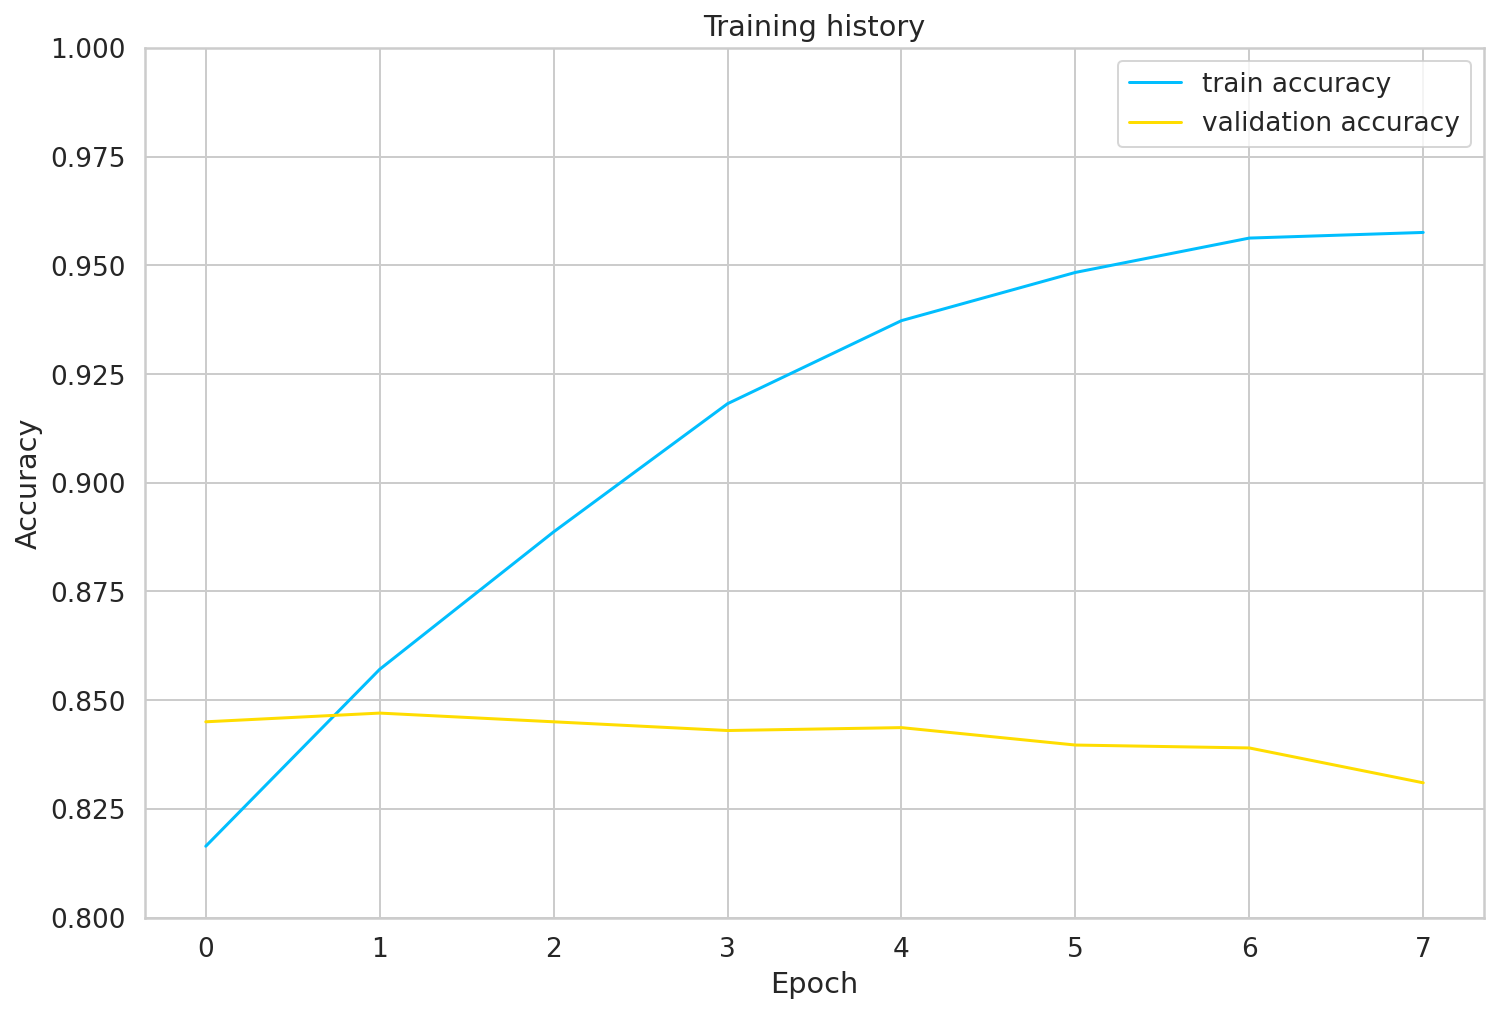

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0.8, 1.0]);
# Explain why you run only 7 epochs and stop the running

In [ ]:
model1 = SentimentClassifier(2)
model1.load_state_dict(torch.load('best_model1_stateb.bin'))
model1 = model1.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
test_acc, test_loss = eval_model(
  model1,
  test_data_loader,
  loss_fn,
  device,
  len(test_dataset)
)

In [ ]:
test_acc.item()

0.7285639137296159

In [ ]:
test_loss

0.644528926796272

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()

  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  enter = True
  with torch.no_grad():
    for d in data_loader:
      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      if(enter):
        print(outputs)
        enter = False


      _, preds = torch.max(outputs, dim=1)
      review_texts.extend(texts)
      predictions.extend(preds)
      softmax_outputs = nn.functional.softmax(outputs, dim=1)
      prediction_probs.extend(softmax_outputs)
      real_values.extend(targets)
  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [ ]:
y_review_texts, y1_pred, y1_pred_proba, y1_test = get_predictions(
  model1,
  test_data_loader
)

tensor([[-1.2414,  0.6484],
        [-2.1486,  1.7539],
        [-1.6653,  1.2157],
        [-0.3108, -0.0929],
        [-0.0208, -0.2772],
        [ 0.4073, -0.8537],
        [-0.7494,  0.4554],
        [-2.2028,  1.7301],
        [-1.5019,  1.2049],
        [-0.2452,  0.0181],
        [-2.2680,  1.9044],
        [-1.3266,  0.7909],
        [-0.8247,  0.3982],
        [ 0.6323, -1.0024],
        [-1.9276,  1.5214],
        [-2.0097,  1.7020]], device='cuda:0')


In [ ]:
y1_pred

tensor([1, 1, 1,  ..., 1, 1, 1])

In [ ]:
y1_pred_proba

tensor([[0.1313, 0.8687],
        [0.0198, 0.9802],
        [0.0531, 0.9469],
        ...,
        [0.2747, 0.7253],
        [0.0121, 0.9879],
        [0.0109, 0.9891]])

In [ ]:
y1_test

tensor([1, 1, 1,  ..., 1, 1, 1])

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
conf_mx = confusion_matrix(y1_test, y1_pred)

In [ ]:
conf_mx

array([[ 234,  485],
       [  31, 1151]])

In [ ]:
from sklearn.metrics import precision_score, recall_score

In [ ]:
precision1 = precision_score(y1_test, y1_pred)

In [ ]:
precision1

0.7035452322738386

In [ ]:
recall1 = recall_score(y1_test, y1_pred)

In [ ]:
recall1

0.9737732656514383

In [ ]:
from sklearn.metrics import f1_score

In [ ]:
f1_score1 = f1_score(y1_test, y1_pred)
f1_score1

0.8168914123491838

##### Classifier 2

In [ ]:
train_data_loader = create_data_loader(train_dataset.content.to_numpy(), train_dataset.more_than_2_star.to_numpy(), tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(val_dataset.content.to_numpy(), val_dataset.more_than_2_star.to_numpy(), tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(test_dataset.content.to_numpy(), test_dataset.more_than_2_star.to_numpy(), tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
model2 = SentimentClassifier(2)
model2 = model2.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
EPOCHS = 8
optimizer = AdamW(model2.parameters(), lr=7e-6, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
%%time
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 30)
  train_acc, train_loss = train_epoch(
    model2,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(train_dataset)
  )
  print(f'Train loss {train_loss} accuracy {train_acc}')  

  val_acc, val_loss = eval_model(
    model2,
    val_data_loader,
    loss_fn,
    device,
    len(val_dataset)
  )
  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()
    
  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)
  if val_acc > best_accuracy:
    torch.save(model2.state_dict(), 'best_model2_stateb.bin')
    best_accuracy = val_acc

Epoch 1/8
------------------------------
Train loss 0.48504142372004283 accuracy 0.7690130880792359
Val   loss 0.40914347419079317 accuracy 0.8069472277889113

Epoch 2/8
------------------------------
Train loss 0.3674419869505669 accuracy 0.8417639429312581
Val   loss 0.4278841762149588 accuracy 0.8056112224448898

Epoch 3/8
------------------------------
Train loss 0.29407031209034434 accuracy 0.8838580356090083
Val   loss 0.500896594665469 accuracy 0.7969271877087509

Epoch 4/8
------------------------------
Train loss 0.24015756961652787 accuracy 0.9151043509020163
Val   loss 0.6117115008664575 accuracy 0.8016032064128257

Epoch 5/8
------------------------------
Train loss 0.20609547793882743 accuracy 0.9339700507015681
Val   loss 0.7702335287876269 accuracy 0.8069472277889113

Epoch 6/8
------------------------------
Train loss 0.1795390459214269 accuracy 0.9448178280863105
Val   loss 0.8268517303092286 accuracy 0.8102872411489647

Epoch 7/8
------------------------------
Train l

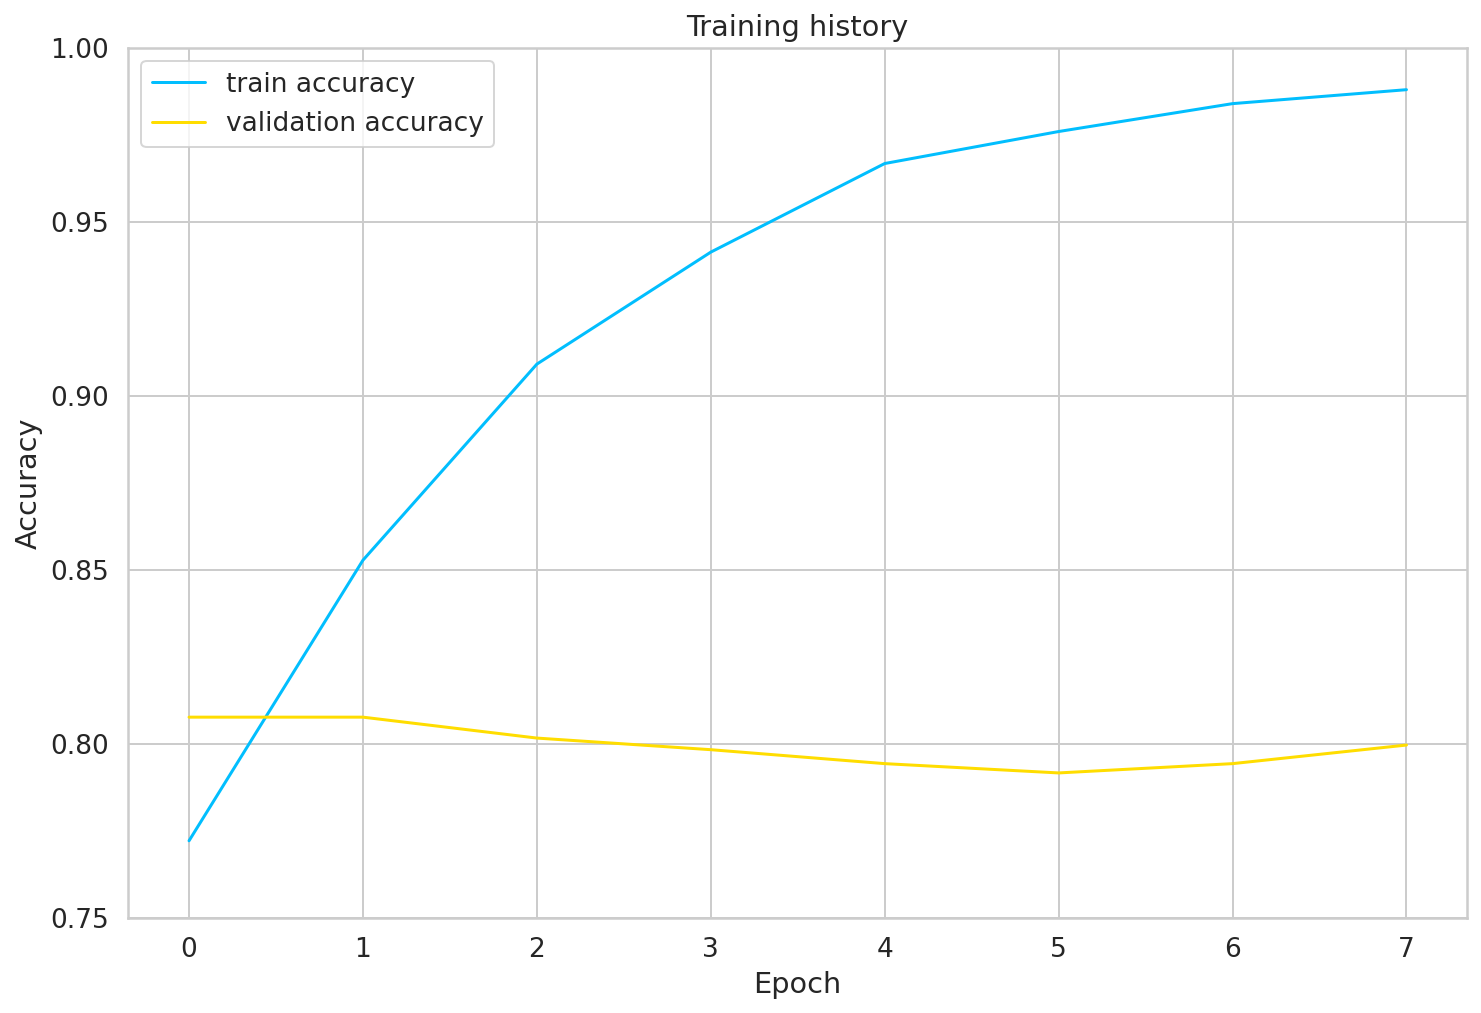

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0.75, 1.0]);
# Explain why you run only 7 epochs and stop the running

In [ ]:
model2 = SentimentClassifier(2)
model2.load_state_dict(torch.load('best_model2_stateb.bin'))
model2 = model2.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
test_acc, test_loss = eval_model(
  model2,
  test_data_loader,
  loss_fn,
  device,
  len(test_dataset)
)

In [ ]:
test_acc.item()

0.7927406628090479

In [ ]:
test_loss

0.8618380135989615

In [ ]:
y_review_texts, y2_pred, y2_pred_proba, y2_test = get_predictions(
  model2,
  test_data_loader
)

tensor([[-0.4125,  0.3815],
        [-2.5440,  2.9962],
        [-2.5467,  2.9377],
        [ 1.4348, -1.6014],
        [ 2.0008, -2.3273],
        [ 2.6084, -2.9292],
        [ 2.3707, -2.6788],
        [-2.9337,  3.2346],
        [-2.7763,  3.0921],
        [ 0.5853, -0.8830],
        [-2.7008,  3.0128],
        [-2.5038,  2.7148],
        [-1.7440,  1.8404],
        [ 0.6512, -1.0341],
        [-2.8148,  3.2049],
        [-2.7301,  3.1430]], device='cuda:0')


In [ ]:
y2_pred

tensor([1, 1, 1,  ..., 0, 1, 1])

In [ ]:
y2_pred_proba

tensor([[0.3113, 0.6887],
        [0.0039, 0.9961],
        [0.0041, 0.9959],
        ...,
        [0.9915, 0.0085],
        [0.0021, 0.9979],
        [0.0021, 0.9979]])

In [ ]:
y2_test

tensor([1, 1, 1,  ..., 1, 1, 1])

In [ ]:
conf_mx = confusion_matrix(y2_test, y2_pred)

In [ ]:
conf_mx

array([[ 495,  224],
       [ 170, 1012]])

In [ ]:
precision2 = precision_score(y2_test, y2_pred)

In [ ]:
precision2

0.8187702265372169

In [ ]:
recall2 = recall_score(y2_test, y2_pred)

In [ ]:
recall2

0.856175972927242

In [ ]:
f1_score2 = f1_score(y2_test, y2_pred)
f1_score2

0.8370554177005789

##### Classifier 3

In [ ]:
train_data_loader = create_data_loader(train_dataset.content.to_numpy(), train_dataset.more_than_3_star.to_numpy(), tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(val_dataset.content.to_numpy(), val_dataset.more_than_3_star.to_numpy(), tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(test_dataset.content.to_numpy(), test_dataset.more_than_3_star.to_numpy(), tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
model3 = SentimentClassifier(2)
model3 = model3.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
EPOCHS = 8
optimizer = AdamW(model3.parameters(), lr=7e-6, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
%%time
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 30)
  train_acc, train_loss = train_epoch(
    model3,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(train_dataset)
  )
  print(f'Train loss {train_loss} accuracy {train_acc}')  

  val_acc, val_loss = eval_model(
    model3,
    val_data_loader,
    loss_fn,
    device,
    len(val_dataset)
  )
  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()
  
    
  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)
  if val_acc > best_accuracy:
    torch.save(model3.state_dict(), 'best_model3_stateb.bin')
    best_accuracy = val_acc

Epoch 1/8
------------------------------
Train loss 0.4467624475839223 accuracy 0.7940101403136423
Val   loss 0.35922241480426587 accuracy 0.8463593854375419

Epoch 2/8
------------------------------
Train loss 0.3189016591596177 accuracy 0.876547576936682
Val   loss 0.4248338730490588 accuracy 0.8343353373413495

Epoch 3/8
------------------------------
Train loss 0.25310251173929865 accuracy 0.9100341940808866
Val   loss 0.48759505437052947 accuracy 0.8383433533734136

Epoch 4/8
------------------------------
Train loss 0.21365316192007391 accuracy 0.931493927602877
Val   loss 0.5622879185396782 accuracy 0.8350033400133601

Epoch 5/8
------------------------------
Train loss 0.1874733173267358 accuracy 0.946232755571277
Val   loss 0.6308685914325983 accuracy 0.8343353373413495

Epoch 6/8
------------------------------
Train loss 0.16315053621694628 accuracy 0.9538969461148449
Val   loss 0.6865896195361509 accuracy 0.8323313293253174

Epoch 7/8
------------------------------
Train los

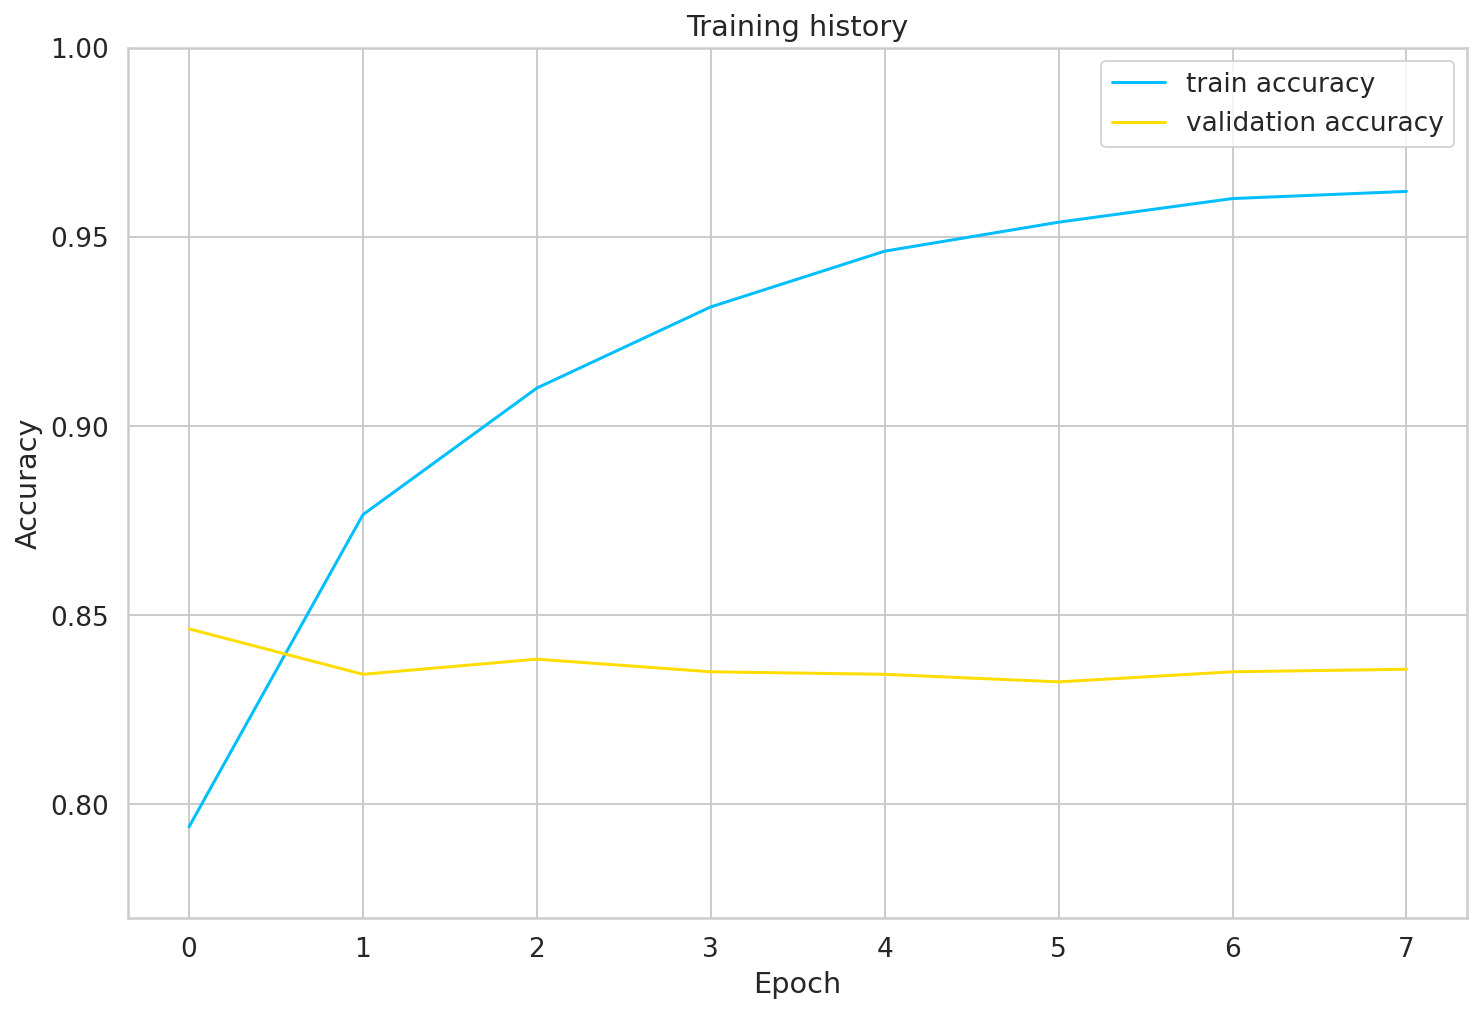

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0.77, 1.0]);
# Explain why you run only 7 epochs and stop the running

In [ ]:
model3 = SentimentClassifier(2)
model3.load_state_dict(torch.load('best_model3_stateb.bin'))
model3 = model3.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
test_acc, test_loss = eval_model(
  model3,
  test_data_loader,
  loss_fn,
  device,
  len(test_dataset)
)

In [ ]:
test_acc.item()

0.8311415044713308

In [ ]:
test_loss

0.38705229333468844

In [ ]:
y_review_texts, y3_pred, y3_pred_proba, y3_test = get_predictions(
  model3,
  test_data_loader
)

tensor([[ 1.1390, -1.4590],
        [ 0.4484, -0.4923],
        [-0.5603,  0.3237],
        [ 1.3590, -1.8274],
        [ 1.4645, -1.8519],
        [ 1.3798, -1.7640],
        [ 0.3210, -0.6179],
        [-1.1760,  1.1351],
        [-1.0844,  0.8956],
        [ 1.3800, -1.7585],
        [-1.4954,  1.3734],
        [ 1.0695, -1.3153],
        [ 0.8543, -1.2485],
        [ 1.3449, -1.7264],
        [-0.5543,  0.3539],
        [-1.2740,  1.3309]], device='cuda:0')


In [ ]:
y3_pred

tensor([0, 0, 1,  ..., 0, 1, 1])

In [ ]:
y3_pred_proba

tensor([[0.9307, 0.0693],
        [0.7192, 0.2808],
        [0.2924, 0.7076],
        ...,
        [0.9672, 0.0328],
        [0.0411, 0.9589],
        [0.0358, 0.9642]])

In [ ]:
y3_test

tensor([0, 0, 1,  ..., 1, 1, 1])

In [ ]:
conf_mx = confusion_matrix(y3_test, y3_pred)

In [ ]:
conf_mx

array([[939, 177],
       [144, 641]])

In [ ]:
precision3 = precision_score(y3_test, y3_pred)

In [ ]:
precision3

0.7836185819070904

In [ ]:
recall3 = recall_score(y3_test, y3_pred)

In [ ]:
recall3

0.8165605095541402

In [ ]:
f1_score3 = f1_score(y3_test, y3_pred)
f1_score3

0.7997504678727386

##### Classifier 4

In [ ]:
train_data_loader = create_data_loader(train_dataset.content.to_numpy(), train_dataset.more_than_4_star.to_numpy(), tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(val_dataset.content.to_numpy(), val_dataset.more_than_4_star.to_numpy(), tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(test_dataset.content.to_numpy(), test_dataset.more_than_4_star.to_numpy(), tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
model4 = SentimentClassifier(2)
model4 = model4.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
EPOCHS = 8
optimizer = AdamW(model4.parameters(), lr=7e-6, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
%%time
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 30)
  train_acc, train_loss = train_epoch(
    model4,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(train_dataset)
  )
  print(f'Train loss {train_loss} accuracy {train_acc}')  

  val_acc, val_loss = eval_model(
    model4,
    val_data_loader,
    loss_fn,
    device,
    len(val_dataset)
  )
  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()
  
  PATH = 'train_valid-epoch{}.pth'.format(epoch)
  if(epoch == 2 or epoch == 6):
    torch.save({
            'epoch': epoch,
            'model_state_dict': model4.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'train_accuracy':train_acc,
            'val_loss': val_loss,
            'val_accuracy': val_acc
            }, PATH)
    
  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)
  if val_acc > best_accuracy:
    torch.save({
            'epoch': epoch,
            'model_state_dict': model4.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'train_accuracy':train_acc,
            'val_loss': val_loss,
            'val_accuracy': val_acc
            }, 'best_model4_state.pth')
    torch.save(model4.state_dict(), 'best_model4_state.bin')
    best_accuracy = val_acc

Epoch 1/8
------------------------------
Train loss 0.35482791875069875 accuracy 0.8534370946822308
Val   loss 0.33777580283423686 accuracy 0.8463593854375419

Epoch 2/8
------------------------------
Train loss 0.24910855637389726 accuracy 0.9083834453484259
Val   loss 0.3796741064796422 accuracy 0.8623914495657984

Epoch 3/8
------------------------------
Train loss 0.20015694158021957 accuracy 0.9372715481664897
Val   loss 0.481887924029155 accuracy 0.8517034068136273

Epoch 4/8
------------------------------
Train loss 0.17382503006687974 accuracy 0.9489446999174626
Val   loss 0.5206061028776333 accuracy 0.8550434201736807

Epoch 5/8
------------------------------
Train loss 0.13768579255177407 accuracy 0.9635656172621153
Val   loss 0.6078643826421033 accuracy 0.8496993987975953

Epoch 6/8
------------------------------
Train loss 0.12715732475954042 accuracy 0.9680462209645089
Val   loss 0.6662482157785524 accuracy 0.850367401469606

Epoch 7/8
------------------------------
Train 

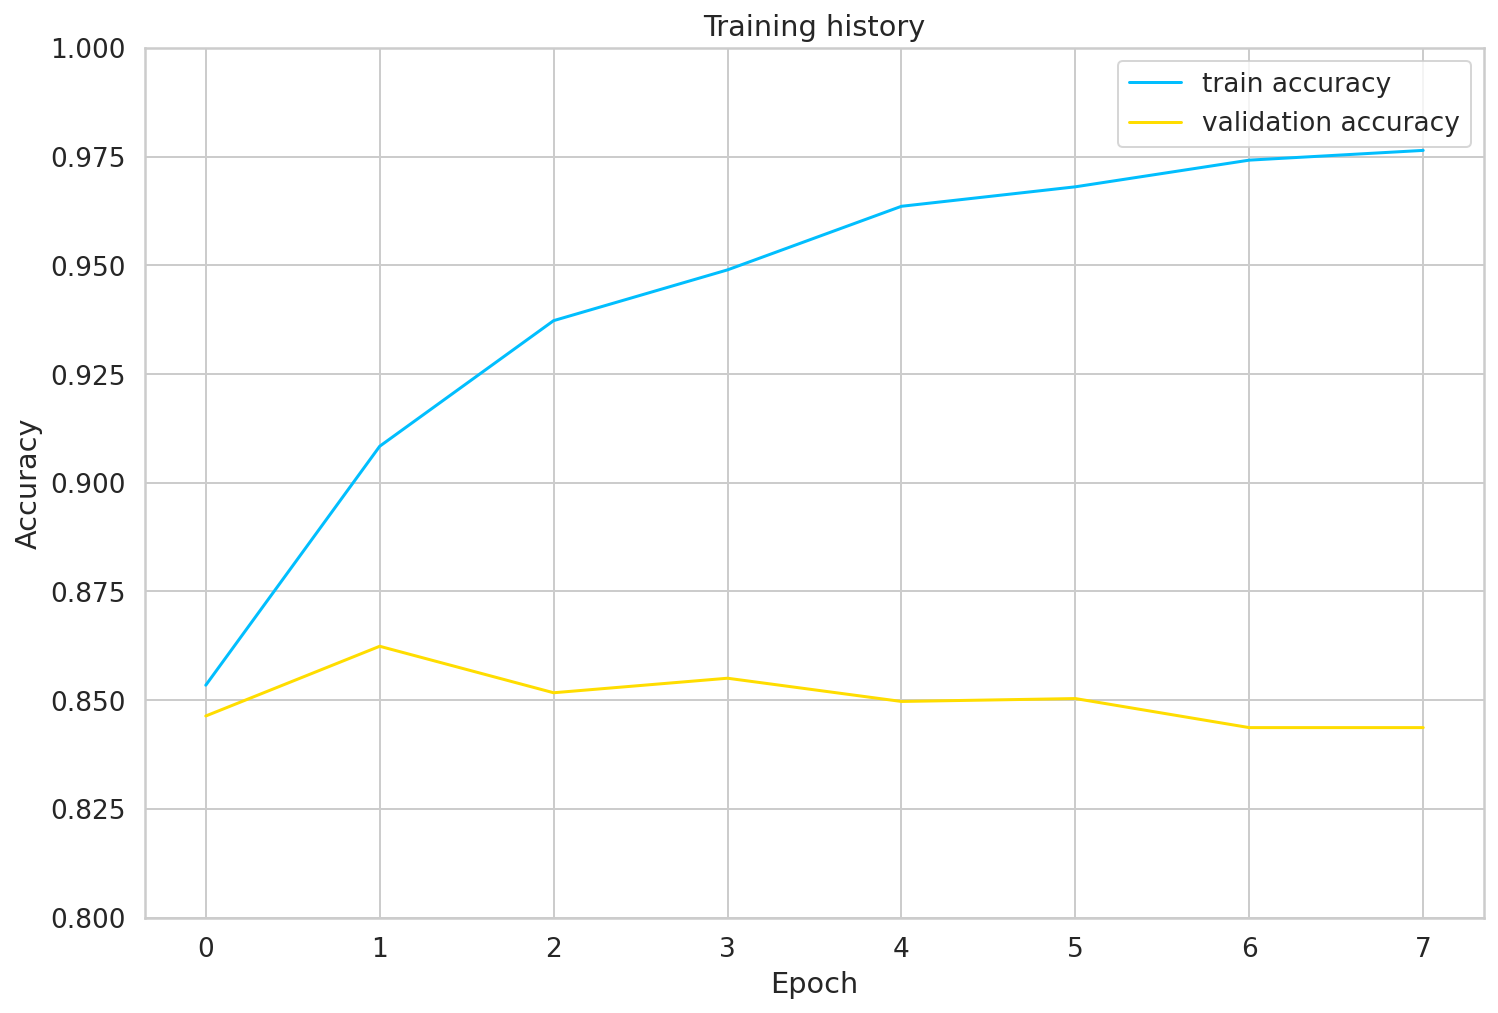

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0.8, 1.0]);
# Explain why you run only 7 epochs and stop the running

In [ ]:
model4 = SentimentClassifier(2)
model4.load_state_dict(torch.load('best_model4_state.bin'))
model4 = model4.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
test_acc, test_loss = eval_model(
  model4,
  test_data_loader,
  loss_fn,
  device,
  len(test_dataset)
)

In [ ]:
test_acc.item()

0.8669121514992109

In [ ]:
test_loss

0.3692332914083445

In [ ]:
y_review_texts, y4_pred, y4_pred_proba, y4_test = get_predictions(
  model4,
  test_data_loader
)

tensor([[ 2.3029, -2.2300],
        [ 1.6836, -1.4677],
        [ 1.1743, -0.9366],
        [ 2.2929, -2.1716],
        [ 2.6701, -2.6124],
        [ 2.3534, -2.3290],
        [ 2.3279, -2.2934],
        [ 1.1831, -1.1209],
        [ 1.3658, -1.2670],
        [ 2.4198, -2.3887],
        [-0.2253,  0.2061],
        [ 2.3131, -2.1179],
        [ 1.2800, -1.1524],
        [ 2.3535, -2.2228],
        [ 1.5786, -1.4484],
        [ 2.0685, -1.9309]], device='cuda:0')


In [ ]:
y4_pred

tensor([0, 0, 0,  ..., 0, 1, 1])

In [ ]:
y4_pred_proba

tensor([[0.9894, 0.0106],
        [0.9590, 0.0410],
        [0.8920, 0.1080],
        ...,
        [0.9915, 0.0085],
        [0.0799, 0.9201],
        [0.0677, 0.9323]])

In [ ]:
y4_test

tensor([0, 0, 0,  ..., 1, 1, 1])

In [ ]:
conf_mx = confusion_matrix(y4_test, y4_pred)

In [ ]:
conf_mx

array([[1392,   96],
       [ 157,  256]])

In [ ]:
precision4 = precision_score(y4_test, y4_pred)

In [ ]:
precision4

0.7272727272727273

In [ ]:
recall4 = recall_score(y4_test, y4_pred)

In [ ]:
recall4

0.6198547215496368

In [ ]:
f1_score4 = f1_score(y4_test, y4_pred)
f1_score4

0.669281045751634

###### precision / recall

In [ ]:
import numpy as np

In [ ]:
def ordinal_classification_predict(binary_predictions):
  classes_proba = []
  classes_proba.append(1-binary_predictions[0][1])
  classes_proba.append(binary_predictions[0][1]-binary_predictions[1][1])
  classes_proba.append(binary_predictions[1][1]-binary_predictions[2][1])
  classes_proba.append(binary_predictions[2][1]-binary_predictions[3][1])
  classes_proba.append(binary_predictions[3][1])

  return np.argmax(classes_proba)
  

In [ ]:
def ordinal_classification_predict_proba(binary_predictions):
  class1 = (1-binary_predictions[0][1])
  class2 = (binary_predictions[0][1]-binary_predictions[1][1])
  class3 = (binary_predictions[1][1]-binary_predictions[2][1])
  class4 = (binary_predictions[2][1]-binary_predictions[3][1])
  class5 = (binary_predictions[3][1])

  return [class1, class2, class3, class4, class5]

In [ ]:
y1_series = pd.Series(y1_pred_proba)
y2_series = pd.Series(y2_pred_proba)
y3_series = pd.Series(y3_pred_proba)
y4_series = pd.Series(y4_pred_proba)

binary_preds = { 'more_than_1_star': y1_series,
                 'more_than_2_star': y2_series,
                 'more_than_3_star': y3_series,
                 'more_than_4_star': y4_series}
binary_preds_df = pd.DataFrame(binary_preds)

In [ ]:
binary_preds_df.head()

,more_than_1_star,more_than_2_star,more_than_3_star,more_than_4_star
0,"(tensor(0.1313), tensor(0.8687))","(tensor(0.3113), tensor(0.6887))","(tensor(0.9307), tensor(0.0693))","(tensor(0.9894), tensor(0.0106))"
1,"(tensor(0.0198), tensor(0.9802))","(tensor(0.0039), tensor(0.9961))","(tensor(0.7192), tensor(0.2808))","(tensor(0.9590), tensor(0.0410))"
2,"(tensor(0.0531), tensor(0.9469))","(tensor(0.0041), tensor(0.9959))","(tensor(0.2924), tensor(0.7076))","(tensor(0.8920), tensor(0.1080))"
3,"(tensor(0.4457), tensor(0.5543))","(tensor(0.9542), tensor(0.0458))","(tensor(0.9603), tensor(0.0397))","(tensor(0.9886), tensor(0.0114))"
4,"(tensor(0.5638), tensor(0.4362))","(tensor(0.9870), tensor(0.0130))","(tensor(0.9650), tensor(0.0350))","(tensor(0.9949), tensor(0.0051))"


In [ ]:
y_pred = binary_preds_df.apply(lambda row: ordinal_classification_predict(row), axis=1)

In [ ]:
y_pred_proba = binary_preds_df.apply(lambda row: ordinal_classification_predict_proba(row), axis=1)

In [ ]:
y_pred.values

array([2, 2, 3, ..., 1, 4, 4])

In [ ]:
y_pred_proba = np.stack(y_pred_proba.values)
y_pred_proba

array([[ 0.13126856,  0.18004292,  0.61941683,  0.05863643,  0.01063528],
       [ 0.01979089, -0.01588047,  0.7153344 ,  0.23971274,  0.04104245],
       [ 0.0530982 , -0.0489645 ,  0.28822094,  0.59960663,  0.1080387 ],
       ...,
       [ 0.2746699 ,  0.71682143, -0.02432027,  0.02427984,  0.0085491 ],
       [ 0.01207286, -0.00993717,  0.03897274,  0.03879046,  0.9201011 ],
       [ 0.01091975, -0.00885302,  0.03370649,  0.03188813,  0.93233865]],
      dtype=float32)

In [ ]:
y_test = test_dataset["score"]
y_test.values

array([2, 2, 3, ..., 4, 4, 4])

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.48763808521830615

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
conf_mx = confusion_matrix(y_test, y_pred)
conf_mx

array([[177,  95,  58,   7,   6],
       [ 65, 157, 111,  38,   5],
       [ 25, 106, 150, 104,  12],
       [  6,  19,  87, 180,  80],
       [  3,  10,  25, 112, 263]])

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="f", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');


In [ ]:
class_names = ['strongly_neg','neg','neutral','pos','strongly_pos']

In [ ]:
import numpy as np

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
from pylab import rcParams

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

In [ ]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
print(row_sums)
norm_conf_mx = conf_mx / row_sums

[[343]
 [376]
 [397]
 [372]
 [413]]


In [ ]:
norm_conf_mx

array([[0.51603499, 0.27696793, 0.16909621, 0.02040816, 0.01749271],
       [0.17287234, 0.41755319, 0.29521277, 0.10106383, 0.01329787],
       [0.06297229, 0.26700252, 0.37783375, 0.26196474, 0.0302267 ],
       [0.01612903, 0.05107527, 0.23387097, 0.48387097, 0.21505376],
       [0.00726392, 0.02421308, 0.06053269, 0.27118644, 0.63680387]])

In [ ]:
df_norm_cm = pd.DataFrame(norm_conf_mx, index=class_names, columns=class_names)

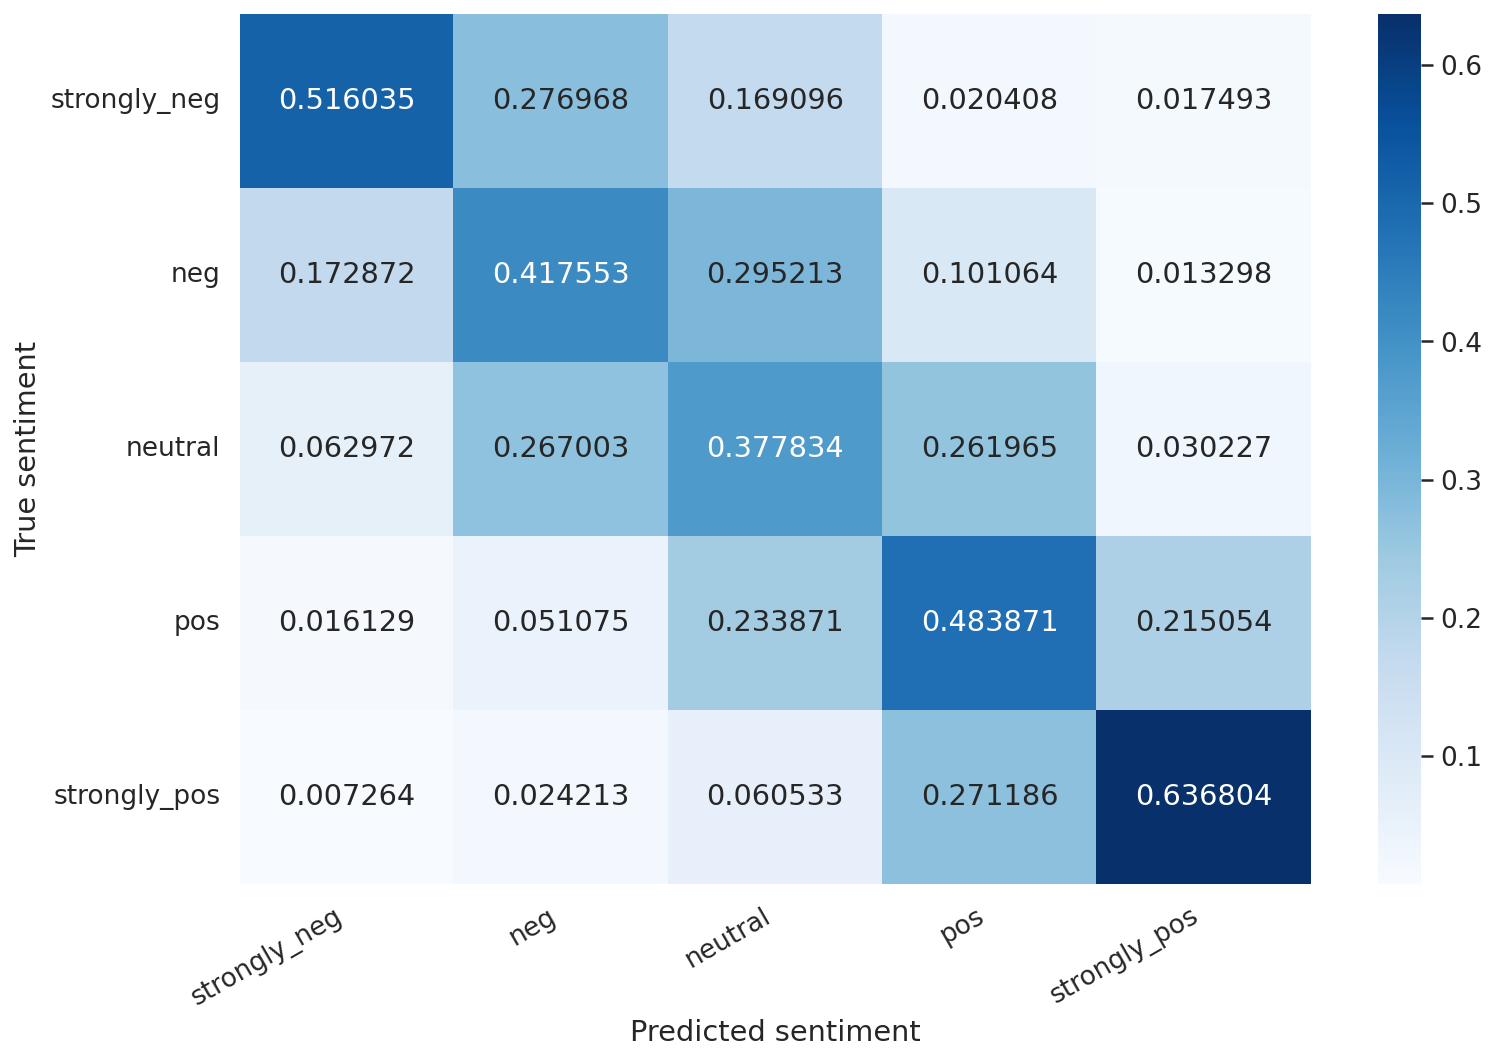

In [ ]:
show_confusion_matrix(df_norm_cm)

In [ ]:
np.fill_diagonal(norm_conf_mx, 0)

In [ ]:
df_norm_cm = pd.DataFrame(norm_conf_mx, index=class_names, columns=class_names)

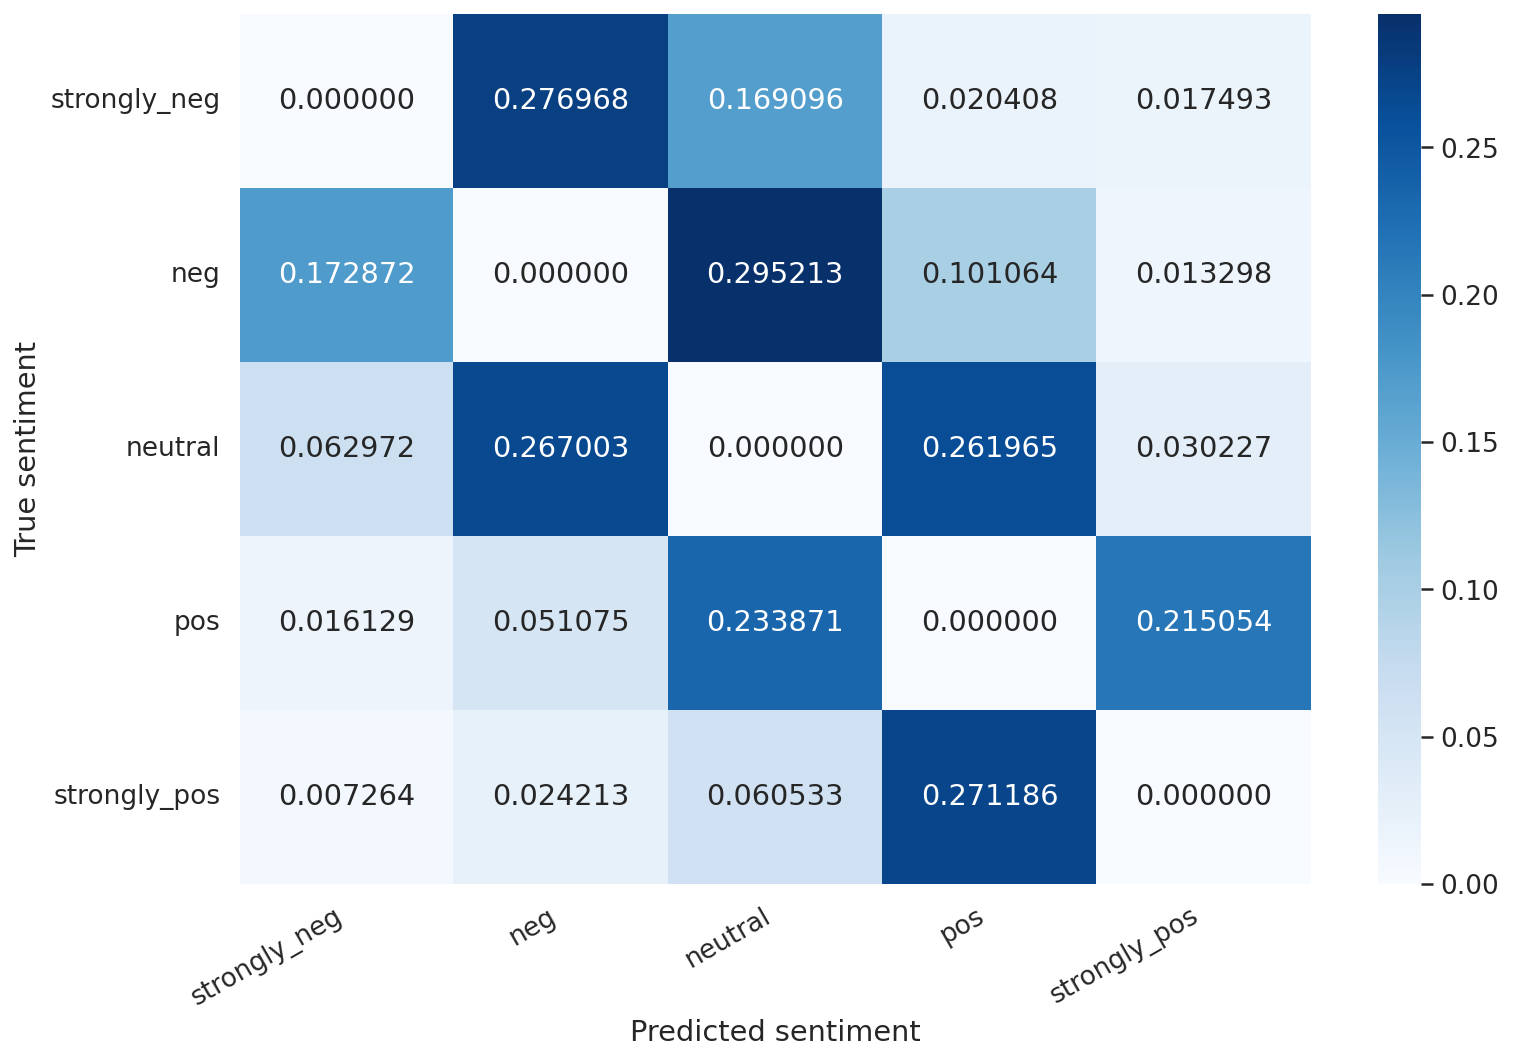

In [ ]:
show_confusion_matrix(df_norm_cm)

Precison / Recall

In [ ]:
from sklearn.preprocessing import label_binarize

In [ ]:
# Use label_binarize to be multi-label like settings
y_test_mult = label_binarize(y_test, classes=[0, 1, 2, 3, 4])
print(y_test_mult)
print(y_pred_proba)

n_classes = y_test_mult.shape[1]
n_classes

[[0 0 1 0 0]
 [0 0 1 0 0]
 [0 0 0 1 0]
 ...
 [0 0 0 0 1]
 [0 0 0 0 1]
 [0 0 0 0 1]]
[[ 0.13126856  0.18004292  0.61941683  0.05863643  0.01063528]
 [ 0.01979089 -0.01588047  0.7153344   0.23971274  0.04104245]
 [ 0.0530982  -0.0489645   0.28822094  0.59960663  0.1080387 ]
 ...
 [ 0.2746699   0.71682143 -0.02432027  0.02427984  0.0085491 ]
 [ 0.01207286 -0.00993717  0.03897274  0.03879046  0.9201011 ]
 [ 0.01091975 -0.00885302  0.03370649  0.03188813  0.93233865]]


5

In [ ]:
print(len(y_test_mult))
print(len(y_pred_proba))

1901
1901


In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

In [ ]:
# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test_mult[:, i],
                                                        y_pred_proba[:, i])
    
    curr_precision = precision[i]
    curr_recall = recall[i]

    precision[i] = precision[i][curr_precision+curr_recall > 0.0]
    recall[i] = recall[i][curr_precision+curr_recall > 0.0]

    average_precision[i] = average_precision_score(y_test_mult[:, i], y_pred_proba[:, i])

In [ ]:
# A "macro-average": Averaging over classes
# ====> Cannot do macro-average by the below approach because:
# len(precision[i]) depend on i (the unique probas in column i)
# the thresholds that based on it the precision & recall are calculated is not the same at the corresponding indices
#precision_sum = precision[0] + precision[1] + precision[2] + precision[3] + precision[4]
#precision["macro"] = precision_sum / 5
#recall_sum = recall[0] + recall[1] + recall[2] + recall[3] + recall[4]
#recall["macro"] = recall_sum / 5

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(y_test_mult.ravel(),
    y_pred_proba.ravel())


# compute F1 score
f1_score = dict()
# for each class
for i in range(n_classes):
  f1_score[i] = 2*((precision[i]*recall[i])/(precision[i]+recall[i]))

f1_score["micro"] = 2*((precision["micro"]*recall["micro"])/(precision["micro"]+recall["micro"]))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


In [ ]:
average_precision["micro"] = average_precision_score(y_test_mult, y_pred_proba,
                                                     average="micro")
average_precision["macro"] = average_precision_score(y_test_mult, y_pred_proba,
                                                     average="macro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))
print('Average precision score, macro-averaged over all classes: {0:0.2f}'
      .format(average_precision["macro"]))

Average precision score, micro-averaged over all classes: 0.46
Average precision score, macro-averaged over all classes: 0.49


Plot the micro-averaged Precision-Recall curve

Text(0.5, 1.0, 'Average precision score, micro-averaged over all classes: AP=0.46')

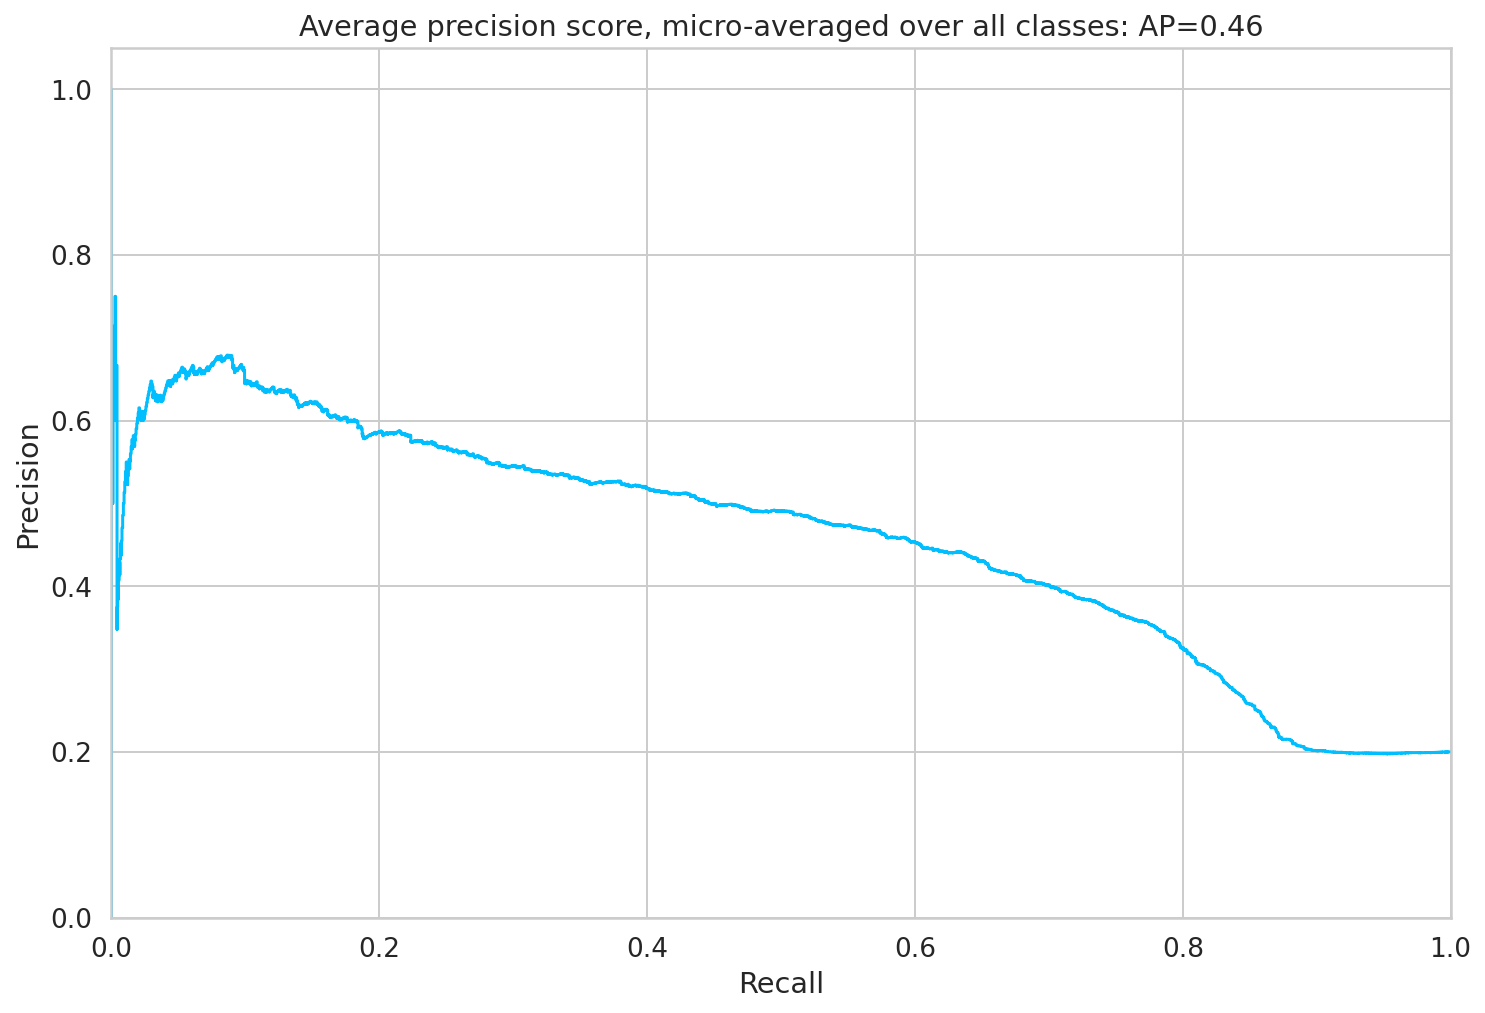

In [ ]:
plt.figure()
plt.step(recall['micro'], precision['micro'], where='post')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(
    'Average precision score, micro-averaged over all classes: AP={0:0.2f}'
    .format(average_precision["micro"]))

Plot Precision-Recall curve for each class and iso-f1 curves

In [ ]:
from itertools import cycle

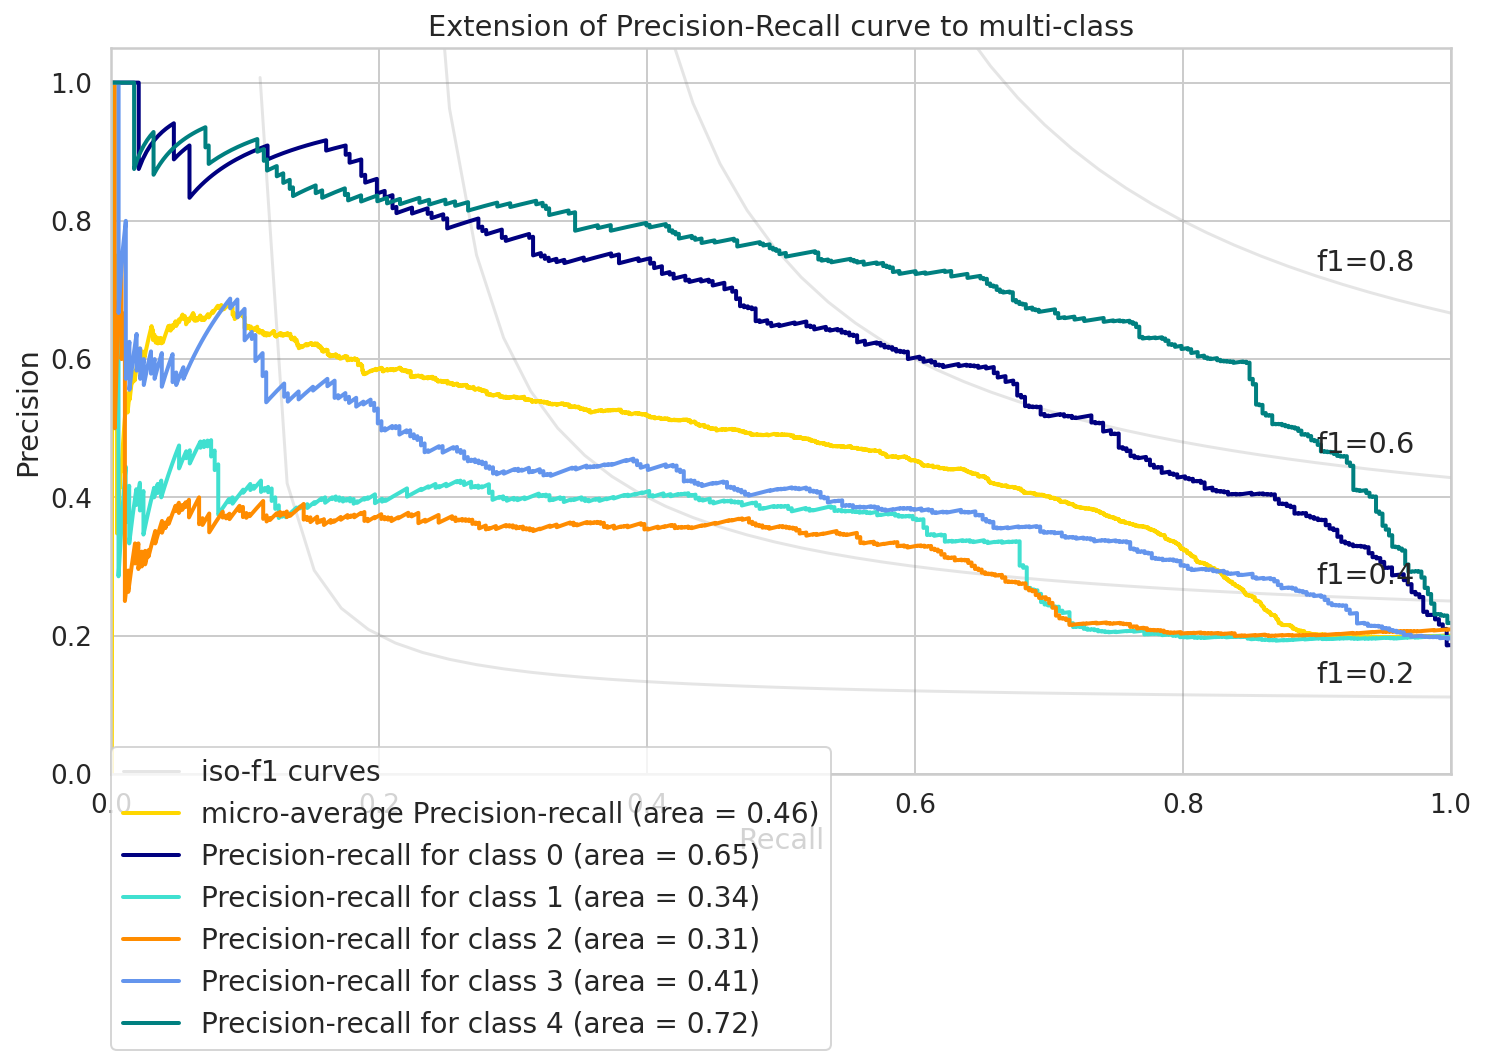

In [ ]:
# setup plot details
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])

plt.figure(figsize=(12, 8))
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

lines.append(l)
labels.append('iso-f1 curves')
l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
lines.append(l)
labels.append('micro-average Precision-recall (area = {0:0.2f})'
              ''.format(average_precision["micro"]))

for i, color in zip(range(n_classes), colors):
    l, = plt.plot(recall[i], precision[i], color=color, lw=2)
    lines.append(l)
    labels.append('Precision-recall for class {0} (area = {1:0.2f})'
                  ''.format(i, average_precision[i]))

fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Extension of Precision-Recall curve to multi-class')
plt.legend(lines, labels, loc=(0, -.38), prop=dict(size=14))


plt.show()
